In [3]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
class CustomLinear(nn.Module):
    """
    Custom linear transformation layer for processing image patches.

    Attributes:
        P (int): Number of patches along one dimension.
        H (int): Height of the input image.
        W (int): Width of the input image.
        C (int): Number of channels in the input image.
        d (int): Dimensionality of the output features.
        input_dim (int): Dimensionality of the input features after patching and flattening.
        linear (nn.Linear): Linear layer for projecting input features to output features.
    """

    def __init__(self, P, H, W, C, d):
        super(CustomLinear, self).__init__()
        self.P = P
        self.H = H
        self.W = W
        self.C = C
        self.d = d

        self.input_dim = (H * C // P) * (W * C // P)

        self.linear = nn.Linear(self.input_dim, d)

    def forward(self, x):
        """
        Forward pass of the CustomLinear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (B, P*P, input_dim), where
                B is the batch size, P*P is the number of patches, and
                input_dim is the dimensionality of each patch.

        Returns:
            torch.Tensor: Output tensor of shape (B, P*P, d), where
                B is the batch size, P*P is the number of patches, and
                d is the dimensionality of the output features.
        """
        B, _, _ = x.shape

        # Flatten the last dimension.
        x = x.view(B, self.P * self.P, self.input_dim)

        # Apply the linear projection.
        x = self.linear(x)

        return x

In [5]:
class MHSA(nn.Module):
    """
    Multi-Head Self-Attention (MHSA) class.

    Attributes:
        d (int): Dimensionality of the model.
        n_heads (int): Number of attention heads.
        head_dim (int): Dimensionality of each attention head.
        query_layer (nn.Linear): Linear layer for query vectors.
        key_layer (nn.Linear): Linear layer for key vectors.
        value_layer (nn.Linear): Linear layer for value vectors.
        out (nn.Linear): Output linear layer.
    """

    def __init__(self, d, n_heads=2):
        super(MHSA, self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by n_heads"

        self.d = d
        self.n_heads = n_heads
        self.head_dim = d // n_heads

        self.query_layer = nn.Linear(in_features=d, out_features=d)
        self.key_layer = nn.Linear(in_features=d, out_features=d)
        self.value_layer = nn.Linear(in_features=d, out_features=d)
        self.out = nn.Linear(in_features=d, out_features=d)

    def split_heads(self, x):
        """
        Split the input tensor into multiple heads.

        Args:
            x (torch.Tensor): Input tensor of shape (N, seq_length, token_dim).

        Returns:
            torch.Tensor: Tensor of shape (N, n_heads, seq_length, head_dim).
        """
        N, seq_length, token_dim = x.shape
        x = x.view(N, seq_length, self.n_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, sequences):
        """
        Forward pass for the MHSA.

        Args:
            sequences (torch.Tensor): Input tensor of shape (N, seq_length, token_dim).

        Returns:
            torch.Tensor: Output tensor of shape (N, seq_length, d).
        """
        # Sequences has shape (N, seq_length, token_dim)
        # Shape is transformed to   (N, seq_length, n_heads, token_dim / n_heads)
        # And finally we return back    (N, seq_length, item_dim)  (through concatenation)
        N, seq_length, token_dim = sequences.shape

        q = self.split_heads(self.query_layer(sequences))
        k = self.split_heads(self.key_layer(sequences))
        v = self.split_heads(self.value_layer(sequences))

        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        self_attn_weights = F.softmax(scores, dim=-1)

        self_attn_output = torch.matmul(self_attn_weights, v)
        self_attn_output = self_attn_output.permute(0, 2, 1, 3).contiguous()
        self_attn_output = self_attn_output.view(N, seq_length, self.d)

        output = self.out(self_attn_output)

        return output

In [6]:
class ViTEncoder(nn.Module):
    """
    Vision Transformer Encoder class.

    Attributes:
        hidden_d (int): Dimensionality of the hidden layer.
        n_heads (int): Number of attention heads.
        norm1 (nn.LayerNorm): Layer normalization layer before MHSA.
        mhsa (MHSA): Multi-Head Self-Attention layer.
        norm2 (nn.LayerNorm): Layer normalization layer before MLP.
        mlp (nn.Sequential): Multi-Layer Perceptron.
    """
    def __init__(self, hidden_d, n_heads):
        super(ViTEncoder, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(normalized_shape=hidden_d)
        self.mhsa = MHSA(d=hidden_d, n_heads=n_heads)
        self.norm2 = nn.LayerNorm(normalized_shape=hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=hidden_d, out_features=4 * hidden_d),
            nn.GELU(),
            nn.Linear(in_features=4 * hidden_d, out_features=hidden_d)
        )

    def forward(self, x):
        """Forward pass for the ViTEncoder.

        Args:
            x (torch.Tensor): Input tensor of shape (B, seq_len, hidden_d).

        Returns:
            torch.Tensor: Output tensor of shape (B, seq_len, hidden_d).
        """
        attn_output = self.mhsa(self.norm1(x))
        x = x + attn_output

        mlp_output = self.mlp(self.norm2(x))
        x = x + mlp_output

        return x

In [7]:
class LightViT(nn.Module):
    """
    Lightweight Vision Transformer (LightViT) class.

    Attributes:
        image_dim (tuple): Dimensions of the input image (B, C, H, W).
        n_patches (int): Number of patches to divide the image into.
        d (int): Dimensionality of the model.
        n_blocks (int): Number of transformer blocks.
        n_heads (int): Number of attention heads.
        num_classes (int): Number of output classes.
        patch_dim (tuple): Dimensions of each patch.
        linear_map (nn.Linear): Linear mapping layer for patches.
        cls_token (nn.Parameter): Learnable classification token.
        pos_embedding (torch.Tensor): Positional embeddings.
        encoders (nn.ModuleList): List of encoder blocks.
        classifier (nn.Sequential): Classification head.
    """

    def __init__(self, image_dim, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10):
        super(LightViT, self).__init__()

        # Class Members.
        self.image_dim = image_dim
        self.n_patches = n_patches
        self.d = d
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.num_classes = num_classes

        B, C, H, W = self.image_dim
        patch_size_H = H // self.n_patches
        patch_size_W = W // self.n_patches
        self.patch_dim = (C, patch_size_H, patch_size_W)

        # 1B) Linear Mapping.
        self.linear_map = CustomLinear(self.n_patches, H, W, C, self.d)

        # 2A) Learnable Parameter.
        self.cls_token = nn.Parameter(data=torch.randn(1, 1, self.d))

        # 2B) Positional embedding.
        self.pos_embedding = self.get_pos_embeddings(embedding_num=n_patches * n_patches + 1, embedding_dim=self.d)

        # 3) Encoder blocks
        self.encoders = nn.ModuleList([ViTEncoder(hidden_d=self.d, n_heads=self.n_heads) for _ in range(self.n_blocks)])

        # 5) Classification Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.d),
            nn.Linear(in_features=self.d, out_features=self.num_classes)
        )
        # TODO: do we need layer norm in classifier?

    def forward(self, images):
        """
        Forward pass for the LightViT model.

        Args:
            images (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output tensor of shape (B, num_classes).
        """
        # Extract the patches from images.
        patches = self.get_patches(images, num_patches_per_dim=self.n_patches)

        # Linearly project patches to embeddings of size d.
        embeddings = self.linear_map(patches)
        # TODO: Check if I should do flattening and reshaping.

        # Classification token is like a learnable kernel of size like a patch with all zeros.
        # We add it to other patches -> shape = (B, num_patches + 1, patch_size*patch_size).
        # We do that for each sample in the batch.
        batch_size = embeddings.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1).to(images.device)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)

        # Add positional embeddings.
        embeddings = embeddings + self.pos_embedding.to(images.device)
        x = embeddings

        # Pass through the encoder.
        for layer in self.encoders:
            x = layer(x)

        # Get classification tokens.
        cls_tokens_learned = x[:, 0]

        # Pass through the classifier.
        output = self.classifier(cls_tokens_learned)

        return output

    @staticmethod
    def get_patches(x, num_patches_per_dim=7):
        """
        Extract patches from an input image.

        Args:
        x (torch.Tensor): Input image of shape (B, C, H, W).
        num_patches_per_dim (int): Number of patches along each dimension.

        Returns:
        torch.Tensor: Output patches of shape (B, num_patches, patch_dim),
                      where num_patches = (H/P) * (W/P) and patch_dim = C * P * P.
        """
        B, C, H, W = x.shape
        patch_size_h = H // num_patches_per_dim
        patch_size_w = W // num_patches_per_dim

        assert H % num_patches_per_dim == 0 and W % num_patches_per_dim == 0, "Image dimensions must be divisible by the number of patches per dimension."

        # Calculate the number of patches along height and width.
        num_patches_h = H // patch_size_h
        num_patches_w = W // patch_size_w
        num_patches = num_patches_h * num_patches_w
        patch_dim = C * patch_size_h * patch_size_w

        # Use unfold to create patches.
        patches = x.unfold(2, size=patch_size_h, step=patch_size_h)  # unfold height dimension
        patches = patches.unfold(3, size=patch_size_w, step=patch_size_w)  # unfold width dimension

        # Re-arrange the patches to satisfy our required dimensions (B, P*P, CxHxW/P*P).
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()

        # Flatten the last dimensions.
        patches = patches.view(B, -1, C * patch_size_h * patch_size_w)

        return patches

    @staticmethod
    def get_pos_embeddings(embedding_num, embedding_dim):
        """
        Generate positional embeddings.

        Args:
            embedding_num (int): Number of embeddings.
            embedding_dim (int): Dimensionality of each embedding.

        Returns:
            torch.Tensor: Positional embeddings of shape (1, embedding_num, embedding_dim).
        """
        # Create a matrix of size embedding_num * embedding_dim (d) to store all positional embeddings.
        pos_embedding = torch.empty(embedding_num, embedding_dim)

        position = torch.arange(0, embedding_num, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))

        # Embed even indices using sin, uneven using cos.
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        pos_embedding = pos_embedding.unsqueeze(0)

        return pos_embedding

In [10]:
def train_model(model, device, train_loader, criterion, optimizer, epoch):
    """Train the model.

    Args:
        model (torch.nn.Module): The model to train.
        device (torch.device): The device to run the training on.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        epoch (int): Number of current epoch.

    Returns:
        list: List of train losses.
    """
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    return loss.item()


def test_model(model, device, test_loader, criterion):
    """
    Test the model.

    Args:
        model (torch.nn.Module): The model to test.
        device (torch.device): The device to run the training on.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        criterion (torch.nn.Module): Loss function.

    Returns:
        float: Loss at the current epoch.
        float: Accuracy at the current epoch.
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
    total_loss = total_loss / len(test_loader)
    total_correct = total_correct/len(test_loader.dataset)
    print(f'Test Loss: {total_loss:.4f}, Accuracy: {total_correct:.4f}')

    return total_loss, total_correct


def train_test_model(model, device, train_loader, test_loader, transforms):
    """
    Train and test the model, then plot the training and test loss over epochs.

    Args:
        model (torch.nn.Module): The model to train and test.
        device (torch.device): The device to run the training on.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        transforms (torchvision.transforms.Compose): Transformations to apply to the data.

    """
    # Define the optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Define the loss.
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    test_accs = []

    # Train the model.
    for epoch in range(5):
        train_loss = train_model(model, device, train_loader, criterion, optimizer, epoch)
        test_loss, test_acc = test_model(model, device, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc * 100.)

    # Plot the training.
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.title(f'Training and test loss of LViT. lr: 0.001. Final Accuracy: {test_accs[-1]:.2f}%')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1, Loss: 1.0843
Test Loss: 0.8197, Accuracy: 0.7149
Epoch 2, Loss: 0.7075
Test Loss: 0.6804, Accuracy: 0.7748
Epoch 3, Loss: 0.5371
Test Loss: 0.4637, Accuracy: 0.8464
Epoch 4, Loss: 0.6618
Test Loss: 0.3922, Accuracy: 0.8757
Epoch 5, Loss: 0.2201
Test Loss: 0.3654, Accuracy: 0.8805


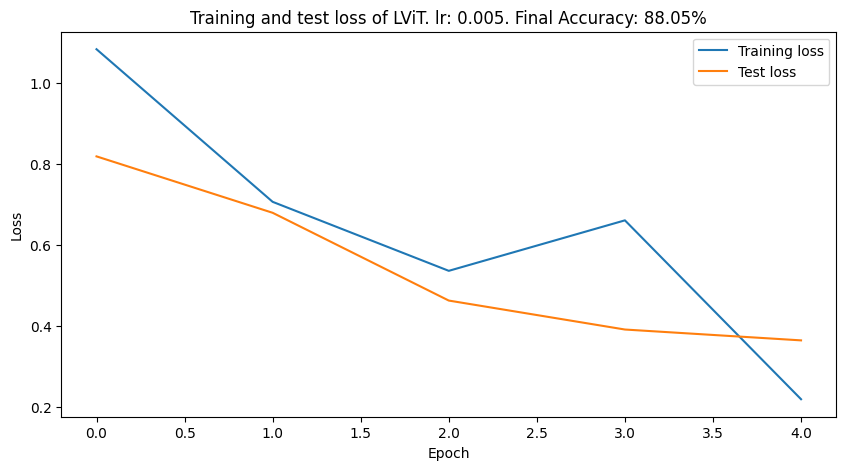

In [58]:
## Train and test on MNIST dataset.

# Check if GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to normalize the data.
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training data.
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

# Download and load the test data
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Define the model.
model = LightViT(image_dim=(32, 1, 28, 28), n_patches=7, d=8)
model.to(device)

train_test_model(model, device, train_loader, test_loader, transform)

Epoch 1, Loss: 0.9256
Test Loss: 0.8003, Accuracy: 0.7006
Epoch 2, Loss: 0.8231
Test Loss: 0.6997, Accuracy: 0.7422
Epoch 3, Loss: 0.3893
Test Loss: 0.6748, Accuracy: 0.7535
Epoch 4, Loss: 0.4906
Test Loss: 0.6165, Accuracy: 0.7755
Epoch 5, Loss: 0.4587
Test Loss: 0.5951, Accuracy: 0.7833


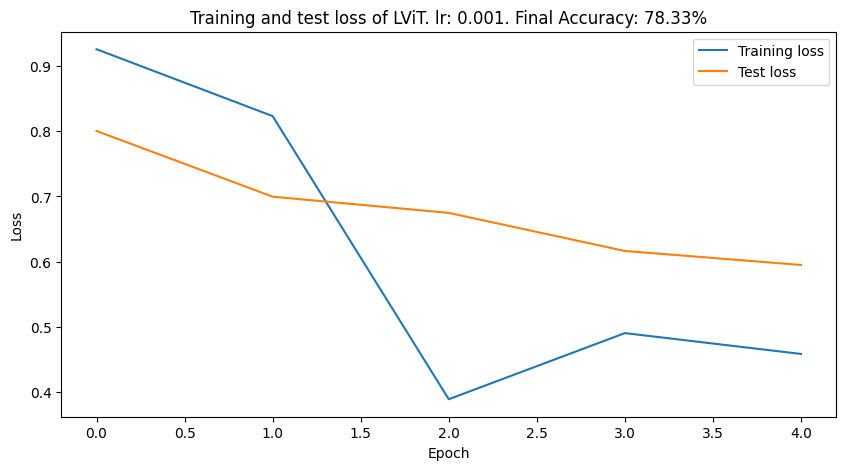

In [11]:
### Train and test on FASHION MNIST dataset.

# Check if GPU is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transform to normalize the data.
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Download and load the training data.
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

# Define the model.
model = LightViT(image_dim=(64, 1, 28, 28), n_patches=7, d=8)
model.to(device)

# Train and test the model
train_test_model(model, device, train_loader, test_loader, transform)